In this code, we will import the samples dictionary from the calibration procedure and create
1. A fit to the data
2. A corner plot

In [1]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Postprocessing WAVE1

In [3]:
##################
### USER INPUT ###
##################

# NOTE: MAKE SURE THAT THE THINNING AND DISCARD VALUES ARE GOOD
# ideal thinning is defined by max(1,int(0.5 * np.min(autocorr)))

# can take a while

# Simulation properties
agg = 'arr'
job_WAVE1 = 'FULL'
maxiter_WAVE1 = 1000
number_WAVE1 = 20000
date_WAVE1 = '2021-06-10' # Date of calibration execution

init_number_WAVE1 = 3
init_WAVE1 = 'frac'

moving_avg = False

thin_WAVE1=50 # Check whether it has been thinned automatically yet!
discard_WAVE1=10000 # Check traceplot for this. If thinning has already taken place, discard should be very small!

###################

# Automated name
json_name_WAVE1 = f"{agg}_WAVE1-{job_WAVE1}_job-{job_WAVE1}_{str(maxiter_WAVE1)}xPSO_{str(number_WAVE1)}xMCMC_{agg}_{str(init_number_WAVE1)}-index-in-{init_WAVE1}_{date_WAVE1}.json"
json_loc_WAVE1 = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict_WAVE1 = json.load(open(f'{json_loc_WAVE1}/{json_name_WAVE1}'))
parNames_mcmc_WAVE1 = ['beta_R', 'beta_U', 'beta_M']
labels_WAVE1 = ['$\\beta^R$', '$\\beta^U$', '$\\beta^M$']
if job_WAVE1 == 'FULL':
    parNames_mcmc_WAVE1 += ['l', 'prev_work', 'prev_rest', 'prev_home']
    labels_WAVE1 += ['$l$', '$\Omega^{work}$', '$\Omega^{rest}$', '$\Omega^{home}$']
nwalkers_WAVE1=int(samples_dict_WAVE1[f'n_chains_{job_WAVE1}'])
samples_WAVE1,flat_samples_WAVE1 = samples_dict_to_emcee_chain(samples_dict_WAVE1, parNames_mcmc_WAVE1, \
                                    nwalkers_WAVE1, discard=discard_WAVE1, thin=thin_WAVE1)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict_WAVE1.keys()
samples_dict_WAVE1[f'start_date_{job_WAVE1}']

'2020-03-05'

In [4]:
samples_dict_WAVE1['warmup']

54

In [5]:
samples_dict_WAVE1[f'end_date_{job_WAVE1}']

'2020-08-07'

## Traceplot

See `results/calibrations/COVID19_SEIRD/{agg}/traceplots`

## Autocorrelation

See `results/calibrations/COVID19_SEIRD/{agg}/autocorrelation`

## Corner plot

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


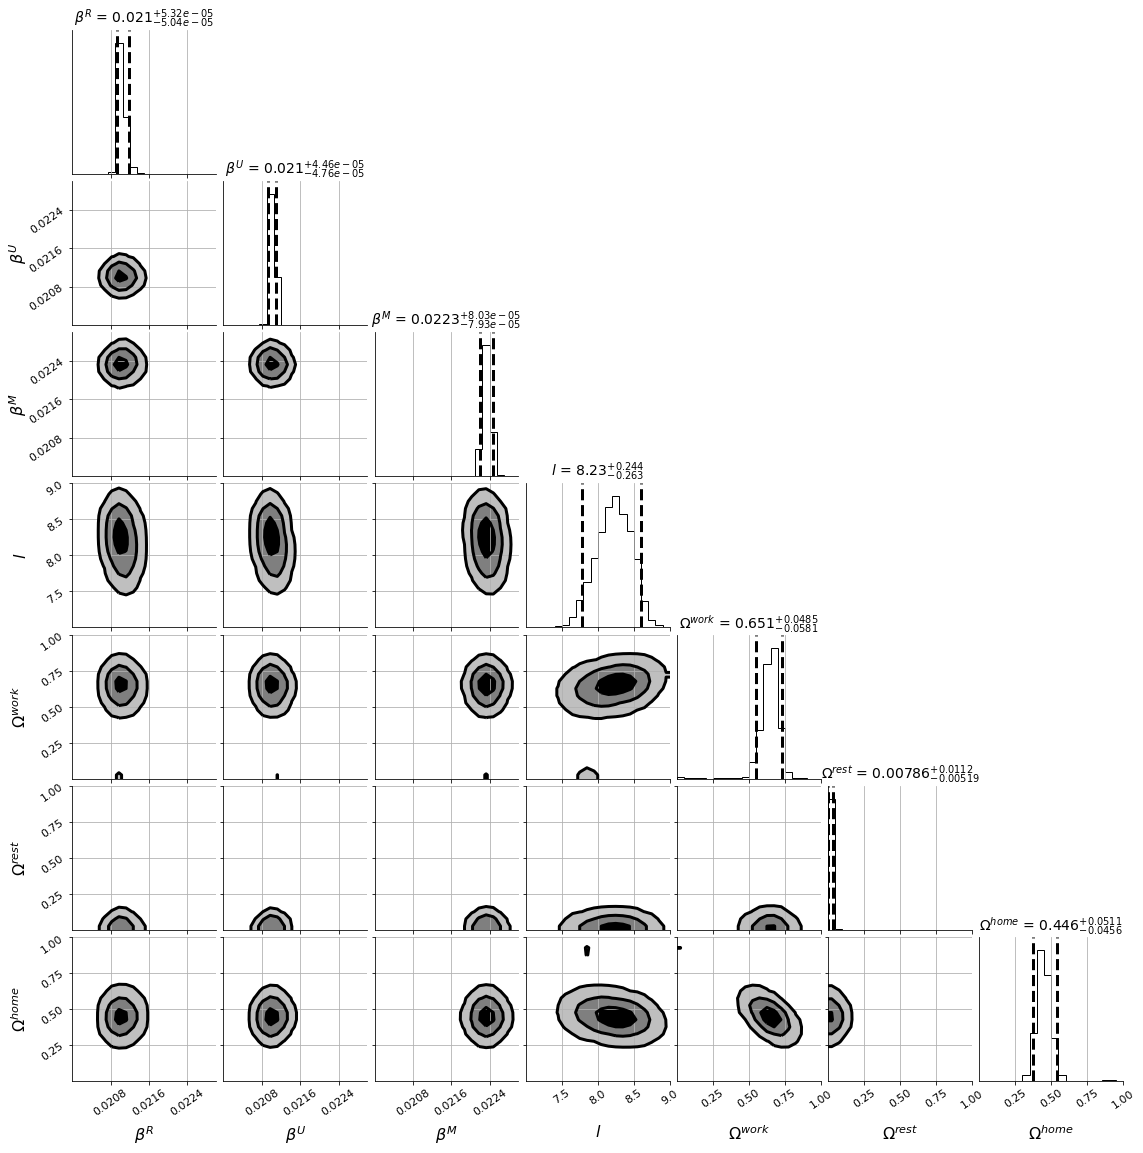

In [3]:
CORNER_KWARGS_WAVE1 = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.0455, 0.9545],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=4,
    title_fmt=".3",
    range=[(0.020, 0.023), (0.020, 0.023), (0.020, 0.023), (7.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],
    xticks=[[], [], [], [], [], [], []]
)
    # range=[(0.02075, 0.02150), (0.02080, 0.02120), (0.02200, 0.02275), (7.2, 9.1), (0.3, 0.9), (0.0, 0.06), (0.25, 0.75)]
    # range=[(0.02075, 0.02150)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples_WAVE1, labels=labels_WAVE1, **CORNER_KWARGS_WAVE1)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=11, rotation=35)

# Save figure
fig.show()
savename_WAVE1 = f'../../results/calibrations/COVID19_SEIRD/arr/cornerplots/{json_name_WAVE1[:-5]}_CORNER.png'
# fig.savefig(savename_WAVE1, dpi=400, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [4]:
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=moving_avg, values='hospitalised_IN')

### Time-dependant data

In [5]:
# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Social behaviour update function from class __call__ (contact_matrix_4prev) and function wrapper to get the right signature
policies_WAVE1 = make_contact_matrix_function(df_google, Nc_all).policies_WAVE1

### Load model

In [6]:
# Load the model parameters dictionary
params_WAVE1 = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params_WAVE1.update({'l' : 5, # formality
               'prev_home' : 0.5, # formality
               'prev_schools': 1.0, # is NOT varied in sampling! And school=0 for all contact before Sept 1st
               'prev_work': 0.5, # formality
               'prev_rest': 0.5 # formality
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params_WAVE1.update({'default_mobility' : None})

# --------------------
# Model initialisation
# --------------------

# Initial states, depending on args parser. Age is hard-coded
age=40
initE = initial_state(dist=init_WAVE1, agg=agg, age=age, number=init_number_WAVE1) # 40-somethings dropped in Brussels (arrival by plane)
initial_states_WAVE1 = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and proper time dependent functions
model_WAVE1 = models.COVID19_SEIRD_spatial(initial_states_WAVE1, params_WAVE1, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE1, 'place' : mobility_wrapper_function}, spatial=agg)

print(f"Warmup: {int(samples_dict_WAVE1['warmup'])} days.")

Warmup: 54 days.


In [7]:
if job_WAVE1 == 'R0':
    def draw_fcn_WAVE1(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job_WAVE1 == 'FULL':
    def draw_fcn_WAVE1(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l'] = samples_dict['l'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        return param_dict

In [8]:
start_sim_WAVE1 = samples_dict_WAVE1[f'start_date_{job_WAVE1}']
# Note that we can choose to simulate further than the calibration date
end_sim_WAVE1 = samples_dict_WAVE1[f'end_date_{job_WAVE1}'] # '2020-09-01'
warmup_WAVE1 = samples_dict_WAVE1['warmup']
n_samples_WAVE1 = 100
out_WAVE1 = model_WAVE1.sim(end_sim_WAVE1,start_date=start_sim_WAVE1,warmup=warmup_WAVE1,N=n_samples_WAVE1,draw_fcn=draw_fcn_WAVE1,samples=samples_dict_WAVE1, verbose=True)

### Plot calibration fit
Note how this _does not_ plot the full parameter dictionary, but only a sample of size `n_samples`. Surely there is a more complete way of going about?

Note also that the central 'median' line that is plotted, is the result of a single simulation. By definition, it is only in the middle of the band at the peak. That is an important nuance.

(0, 800)

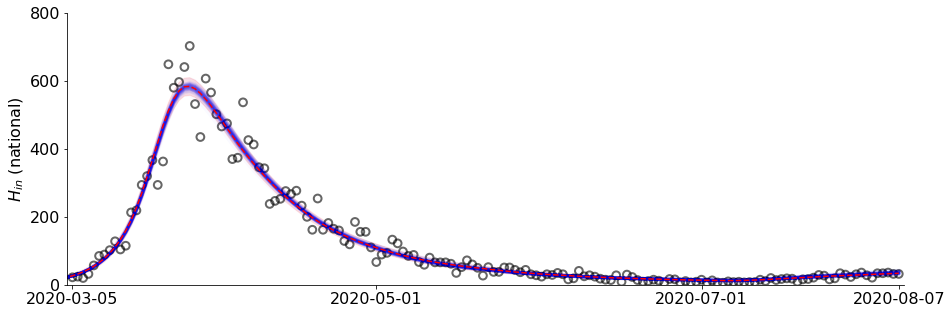

In [9]:
savename_WAVE1 = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT.png'
savename_WAVE1=None
NIS_WAVE1=None
# savename_WAVE1=f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT-{NIS_WAVE1}.png'

start_calibration_WAVE1 = samples_dict_WAVE1[f'start_date_{job_WAVE1}']
end_calibration_WAVE1 = samples_dict_WAVE1[f'end_date_{job_WAVE1}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw_WAVE1 = plot_calibration_fit(out_WAVE1, df_sciensano, 'H_in', start_sim_WAVE1, end_sim_WAVE1, \
            start_calibration=start_calibration_WAVE1, end_calibration=end_calibration_WAVE1, NIS=NIS_WAVE1, \
            savename=None, conf_int=0.05, show_all=True, ax=ax)
ax.grid(False)
ax.set_xticks(['2020-03-05', '2020-05-01', '2020-07-01', '2020-08-07'])
ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel(r'$H_{in}$ (national)', fontsize=16)
ax.set_ylim([0, 800])

# plt.savefig(savename_WAVE1, dpi=400, bbox_inches='tight')

(-0.3, 6)

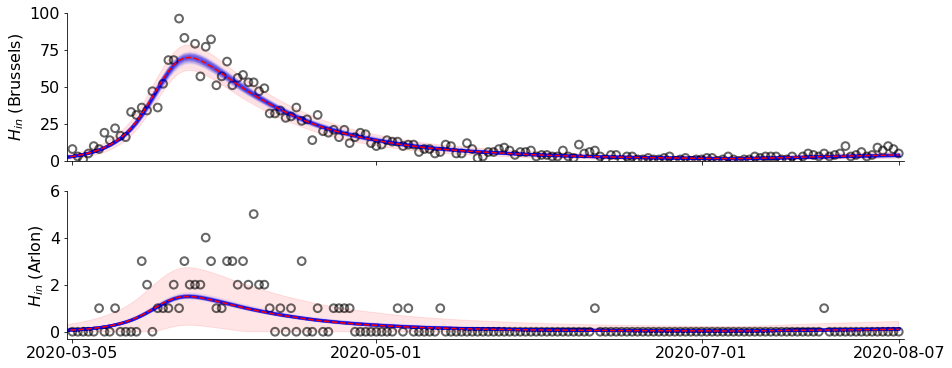

In [10]:
savename_WAVE1 = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT.png'
savename_WAVE1=None
NIS_WAVE1=[21000, 81000]
# savename_WAVE1=f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT-{NIS_WAVE1[0]}-{NIS_WAVE1[1]}.png'

start_calibration_WAVE1 = samples_dict_WAVE1[f'start_date_{job_WAVE1}']
end_calibration_WAVE1 = samples_dict_WAVE1[f'end_date_{job_WAVE1}']

fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(15,6))

axs[0], median_draw_WAVE1 = plot_calibration_fit(out_WAVE1, df_sciensano, 'H_in', start_sim_WAVE1, end_sim_WAVE1, \
            start_calibration=start_calibration_WAVE1, end_calibration=end_calibration_WAVE1, NIS=NIS_WAVE1[0], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[0])
axs[0].grid(False)

axs[1], median_draw_WAVE1 = plot_calibration_fit(out_WAVE1, df_sciensano, 'H_in', start_sim_WAVE1, end_sim_WAVE1, \
            start_calibration=start_calibration_WAVE1, end_calibration=end_calibration_WAVE1, NIS=NIS_WAVE1[1], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[1])
axs[1].grid(False)
axs[1].set_xticks(['2020-03-05', '2020-05-01', '2020-07-01', '2020-08-07'])
axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[0].set_ylabel(r'$H_{in}$ (Brussels)', fontsize=16)
axs[1].set_ylabel(r'$H_{in}$ (Arlon)', fontsize=16)
axs[0].set_ylim([0, 100])
axs[1].set_ylim([-0.3, 6])

# plt.savefig(savename_WAVE1, dpi=400, bbox_inches='tight')

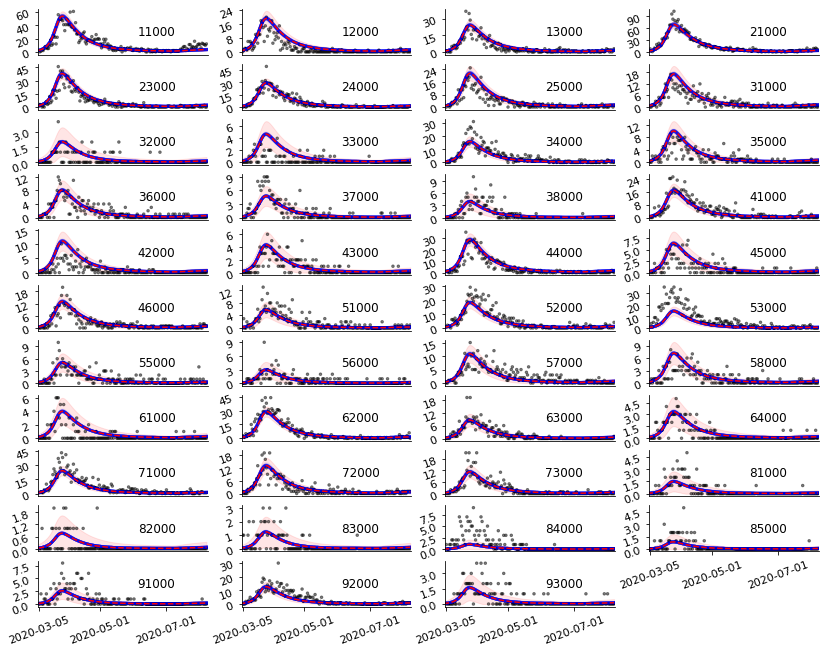

In [11]:
# fig, axs = plt.subplots(ncols=4, nrows=11, sharex=True, figsize=(16,22))

all_NIS = pd.read_csv('../../data/raw/GIS/NIS_arrondissement.csv')['NIS'].values

fig, axs = plt.subplots(nrows=11, ncols=4, sharex=False, figsize=(14, 11))

for row in range(11):
    for col in range(4):
        NIS_index = 4*row+col
        if NIS_index < 43:
            axs[row,col], median_draw_WAVE1 = plot_calibration_fit(out_WAVE1, df_sciensano, 'H_in', start_sim_WAVE1, end_sim_WAVE1, \
            start_calibration=start_calibration_WAVE1, end_calibration=end_calibration_WAVE1, NIS=all_NIS[NIS_index], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[row,col], scatter_size=2)
#             axs[row,col].set_xticks(['2020-03-05', '2020-05-01', '2020-07-01'])
            axs[row,col].set_xticks([])
            axs[row,col].tick_params(axis='both', labelsize=12)
            axs[row,col].set_title(f'{all_NIS[NIS_index]}', y=0.3, x=0.7)
            axs[row,col].set_ylabel(None)
            axs[row,col].grid(False)
            if (row==9 and col==3) or (row==10 and col!=3):
                axs[row,col].set_xticks(['2020-03-05', '2020-05-01', '2020-07-01'])
        else:
            axs[row,col].set_visible(False)
            
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=11, rotation=20)
            
savename_WAVE1_all = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT-all'
# plt.savefig(savename_WAVE1_all, dpi=400, bbox_inches='tight')

### Experiment with various social policies to fit August bump

In [12]:
# Reload data in case this is needed

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Define social contact matrix
contact_matrix_function = make_contact_matrix_function(df_google, Nc_all)

ramp_fun = make_contact_matrix_function(df_google, Nc_all).ramp_fun

# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

In [13]:
# Define alternative policies_WAVE1 time-dependant function
def policies_WAVE1_altered(t, states, param, l , prev_schools, prev_work, prev_rest, prev_home):
    '''
    Function that returns the time-dependant social contact matrix Nc for the first 2020 COVID-19 wave. Includes a manual tweaking of the 2020 COVID-19 Antwerp summer wave.

    Input
    -----
    t : Timestamp
        simulation time
    states : xarray
        model states
    param : dict
        model parameter dictionary
    l : float
        Compliance parameter for ramp_fun
    tau : float
        Compliance parameter for ramp_fun
    prev_{location} : float
        Effectivity of contacts at {location}

    Returns
    -------
    CM : np.array
        Effective contact matrix (output of __call__ function)
    '''
    all_contact = Nc_all['total']
    all_contact_no_schools = Nc_all['total'] - Nc_all['schools']

    # Convert l to dates
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-06-27') # start of summer holidays
    t4 = pd.Timestamp('2020-08-05') # end of 'second wave' in Antwerp        
    t5 = pd.Timestamp('2020-08-21') # end of summer holidays # Used to be 2020-09-01

    # Before lockdown 03-15
    if t <= t1:
        return all_contact
    
    # At the start of lockdown 03-15
    elif t1 < t <= t1 + l_days:
        t = pd.Timestamp(t.date())
        policy_old = all_contact
        policy_new = contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=prev_work, prev_rest=prev_rest,
                                   school=0)
        return ramp_fun(policy_old, policy_new, t, t1, l)
    
    # After adjustment to lockdown 03-15 + l
    elif t1 + l_days < t <= t2:
        t = pd.Timestamp(t.date())
        return contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=prev_work, prev_rest=prev_rest, 
                              school=0)
    # Gradual reopening of the schools (but it is still set to 0 because only 4 years had class and most had class outside)
    elif t2 < t <= t3:
        t = pd.Timestamp(t.date())
        return contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=0.64, prev_rest=prev_rest, 
                              school=0)                  
    ## WARNING: During the summer of 2020, highly localized clusters appeared in Antwerp city, and lockdown measures were taken locally
    ## Do not forget this is a national-level model, you need a spatially explicit model to correctly model localized phenomena.
    ## The following is an ad-hoc tweak to assure a fit on the data during summer in order to be as accurate as possible with the seroprelevance
    
    # Start of holiday with reaction delay
    # prev_work = 0.651 (from calibration)
    elif t3 < t <= t3 + l_days:
        policy_old = contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=0.64,\
                                             prev_rest=prev_rest, school=0)
        policy_new = contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=0.64, prev_rest=0.0, school=0)
        return ramp_fun(policy_old, policy_new, t, t3, l)
    
    # Summer holiday and 'second wave', notably in Antwerp
    elif t3 + l_days < t <= t4:
        return contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, \
                                       prev_work=prev_work, prev_rest=0.90, school=0) # Changed from 0.75
    
    # Beyond the peak of the summer 'wave'
    elif t4 < t <= t5:
        return contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=0.25, prev_rest=0.25, # Changed from 0.05, 0.05
                            school=0)
    
    # Anything beyond t5 (which is beyond the scope of WAVE1, as this is where WAVE2 starts)
    else:
        return contact_matrix_function(t, prev_home=prev_home, prev_schools=prev_schools, prev_work=0.8, prev_rest=0.8, # Changed from prev_work, prev_rest
                            school=1)

In [14]:
# Define median draw function to reduce the need for a high number of draws
if job_WAVE1 == 'R0':
    def draw_fcn_median_WAVE1(param_dict,samples_dict):
        # pick median value from the dictionary
        idx = np.argsort(np.array(samples_dict['beta_R']))[len(np.array(samples_dict['beta_R']))//2]
        param_dict['beta_R'] = samples_dict['beta_R'][idx]
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job_WAVE1 == 'FULL':
    def draw_fcn_median_WAVE1(param_dict,samples_dict):
        # pick median value from the dictionary
        idx = np.argsort(np.array(samples_dict['beta_R']))[len(np.array(samples_dict['beta_R']))//2]
        param_dict['beta_R'] = samples_dict['beta_R'][idx]
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l'] = samples_dict['l'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        return param_dict

In [15]:
# Load the model parameters dictionary
params_WAVE1_altered = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params_WAVE1.update({'l' : 5, # formality
               'prev_home' : 0.5, # formality
               'prev_schools': 1.0, # is fixed but is only relevant if school != 0
               'prev_work': 0.5, # formality
               'prev_rest': 0.5 # formality
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params_WAVE1.update({'default_mobility' : None})

# --------------------
# Model initialisation
# --------------------

# Initial states, depending on args parser. Age is hard-coded
age=40
initE = initial_state(dist=init_WAVE1, agg=agg, age=age, number=init_number_WAVE1) # 40-somethings dropped in Brussels (arrival by plane)
initial_states_WAVE1 = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and proper time dependent functions
model_WAVE1_altered = models.COVID19_SEIRD_spatial(initial_states_WAVE1, params_WAVE1, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE1_altered, 'place' : mobility_wrapper_function}, spatial=agg)

start_sim_WAVE1 = samples_dict_WAVE1[f'start_date_{job_WAVE1}']
# Note that we can choose to simulate further than the calibration date
end_sim_WAVE1 = '2020-09-01'
warmup_WAVE1 = samples_dict_WAVE1['warmup']
n_samples_WAVE1_altered = 100
out_WAVE1_altered = model_WAVE1_altered.sim(end_sim_WAVE1,start_date=start_sim_WAVE1,warmup=warmup_WAVE1,N=n_samples_WAVE1_altered,\
                                            draw_fcn=draw_fcn_median_WAVE1,samples=samples_dict_WAVE1, verbose=True)

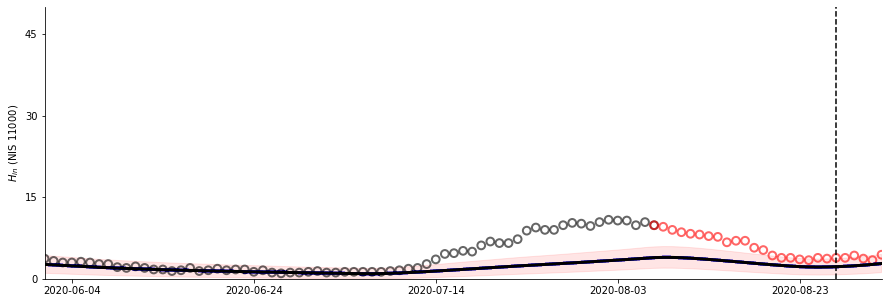

In [22]:
# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
# With moving average
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')

savename_WAVE1 = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT.png'
savename_WAVE1=None
NIS_WAVE1=11000

start_calibration_WAVE1 = start_sim_WAVE1
end_calibration_WAVE1 = samples_dict_WAVE1[f'end_date_{job_WAVE1}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw_WAVE1 = plot_calibration_fit(out_WAVE1_altered, df_sciensano, 'H_in', start_sim_WAVE1, end_sim_WAVE1, \
            start_calibration=start_calibration_WAVE1, end_calibration=end_calibration_WAVE1, NIS=NIS_WAVE1, \
            savename=savename_WAVE1, conf_int=0.05, show_all=True, ax=ax)
ax.grid(False)
ax.set_xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-09-01'))
# 60 is national top value in data in the Summer
ax.set_ylim(0,50)

final_time = pd.Timestamp('2020-09-01')
initial_condition_date = pd.Timestamp('2020-08-27')

# Show simulation with median value at September 1st in black
if NIS_WAVE1:
    ts_sept1 = out_WAVE1_altered['H_in'].sel(place=NIS_WAVE1).sum(dim='Nc').sel(time=final_time, method='nearest').values
    median_draw = np.argsort(ts_sept1)[len(ts_sept1)//2]
    out_median = out_WAVE1_altered.sel(draws=median_draw).sel(place=NIS_WAVE1).sum(dim='Nc')
else:
    ts_sept1 = out_WAVE1_altered['H_in'].sum(dim='place').sum(dim='Nc').sel(time=final_time, method='nearest').values
    median_draw = np.argsort(ts_sept1)[len(ts_sept1)//2]
    out_median = out_WAVE1_altered.sel(draws=median_draw).sum(dim='Nc').sum(dim='place')
ax.plot(out_median['time'], out_median['H_in'].values, color='black')

ax.axvline(initial_condition_date, color='k', linestyle='--', linewidth=1.5)

# plt.savefig("summer-bump_21000.png", dpi=400, bbox_inches='tight')

### Save subjects per states at particular date (start dict for next waves)
Save from run that has the medium value at September 1st (which is _not_ the same as the run with medium value at the peak of the first wave!)

In [67]:
states_xarray = out_WAVE1_altered.sel(time=initial_condition_date, method='nearest').sel(draws=median_draw)

final_states = {}
for state in list(states_xarray.data_vars.keys()):
    final_states.update({state: states_xarray[state].values.tolist()})
    
# Saves list (43 entries) of lists (9 entries) for each state.
save_suffix = 'fiddling-08aug21'
final_states_json = f'{json_loc_WAVE1}/{agg}_WAVE1_job-{job_WAVE1}_{str(maxiter_WAVE1)}xPSO_{str(number_WAVE1)}xMCMC_{agg}_{str(init_number_WAVE1)}-index-in-{init_WAVE1}_{date_WAVE1}_states_{str(initial_condition_date.date())}_{save_suffix}.json'
with open(final_states_json, 'w') as fsj:
    json.dump(final_states, fsj)
    print(f"Saved as {final_states_json}")

Saved as ../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_fiddling-08aug21.json


# Postprocessing WAVE2

In [5]:
##################
### USER INPUT ###
##################

# can take a while

# Simulation properties
agg = 'arr'
job_WAVE2 = 'FULL'
maxiter_WAVE2 = 1000
number_WAVE2 = 20000
date_WAVE2 = '2021-08-24' # Date of calibration execution

moving_avg = False

###################

# Automated name
json_name_WAVE2 = f"{agg}_WAVE2-{job_WAVE2}_job-{job_WAVE2}_{str(maxiter_WAVE2)}xPSO_{str(number_WAVE2)}xMCMC_{agg}_{date_WAVE2}.json"
# json_name_WAVE2 = 'arr_WAVE2-FULL_test_delete_me_2021-06-07.json'
json_loc_WAVE2 = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict_WAVE2 = json.load(open(f'{json_loc_WAVE2}/{json_name_WAVE2}'))
parNames_mcmc_WAVE2 = ['beta_R', 'beta_U', 'beta_M']
labels_WAVE2 = ['$\\beta^R$', '$\\beta^U$', '$\\beta^M$']
if job_WAVE2 == 'FULL':
    parNames_mcmc_WAVE2 += ['l', 'prev_schools', 'prev_work', 'prev_rest', 'prev_home']
    labels_WAVE2 += ['$l$', '$\Omega^{schools}$', '$\Omega^{work}$', '$\Omega^{rest}$', '$\Omega^{home}$']
nwalkers_WAVE2=int(samples_dict_WAVE2[f'n_chains_{job_WAVE2}'])
discard_WAVE2=2000 # see traceplot to distinguish discard and thin values
thin_WAVE2=50
samples_WAVE2,flat_samples_WAVE2 = samples_dict_to_emcee_chain(samples_dict_WAVE2, parNames_mcmc_WAVE2, nwalkers_WAVE2, discard=discard_WAVE2, thin=thin_WAVE2)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict_WAVE2.keys()

dict_keys(['beta_R', 'beta_U', 'beta_M', 'l', 'prev_schools', 'prev_work', 'prev_rest', 'prev_home', 'warmup', 'start_date_FULL', 'end_date_FULL', 'n_chains_FULL'])

## Traceplot

See `results/calibrations/COVID19_SEIRD/{agg}/traceplots`

## Autocorrelation

See `results/calibrations/COVID19_SEIRD/{agg}/autocorrelation`

## Corner plots

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


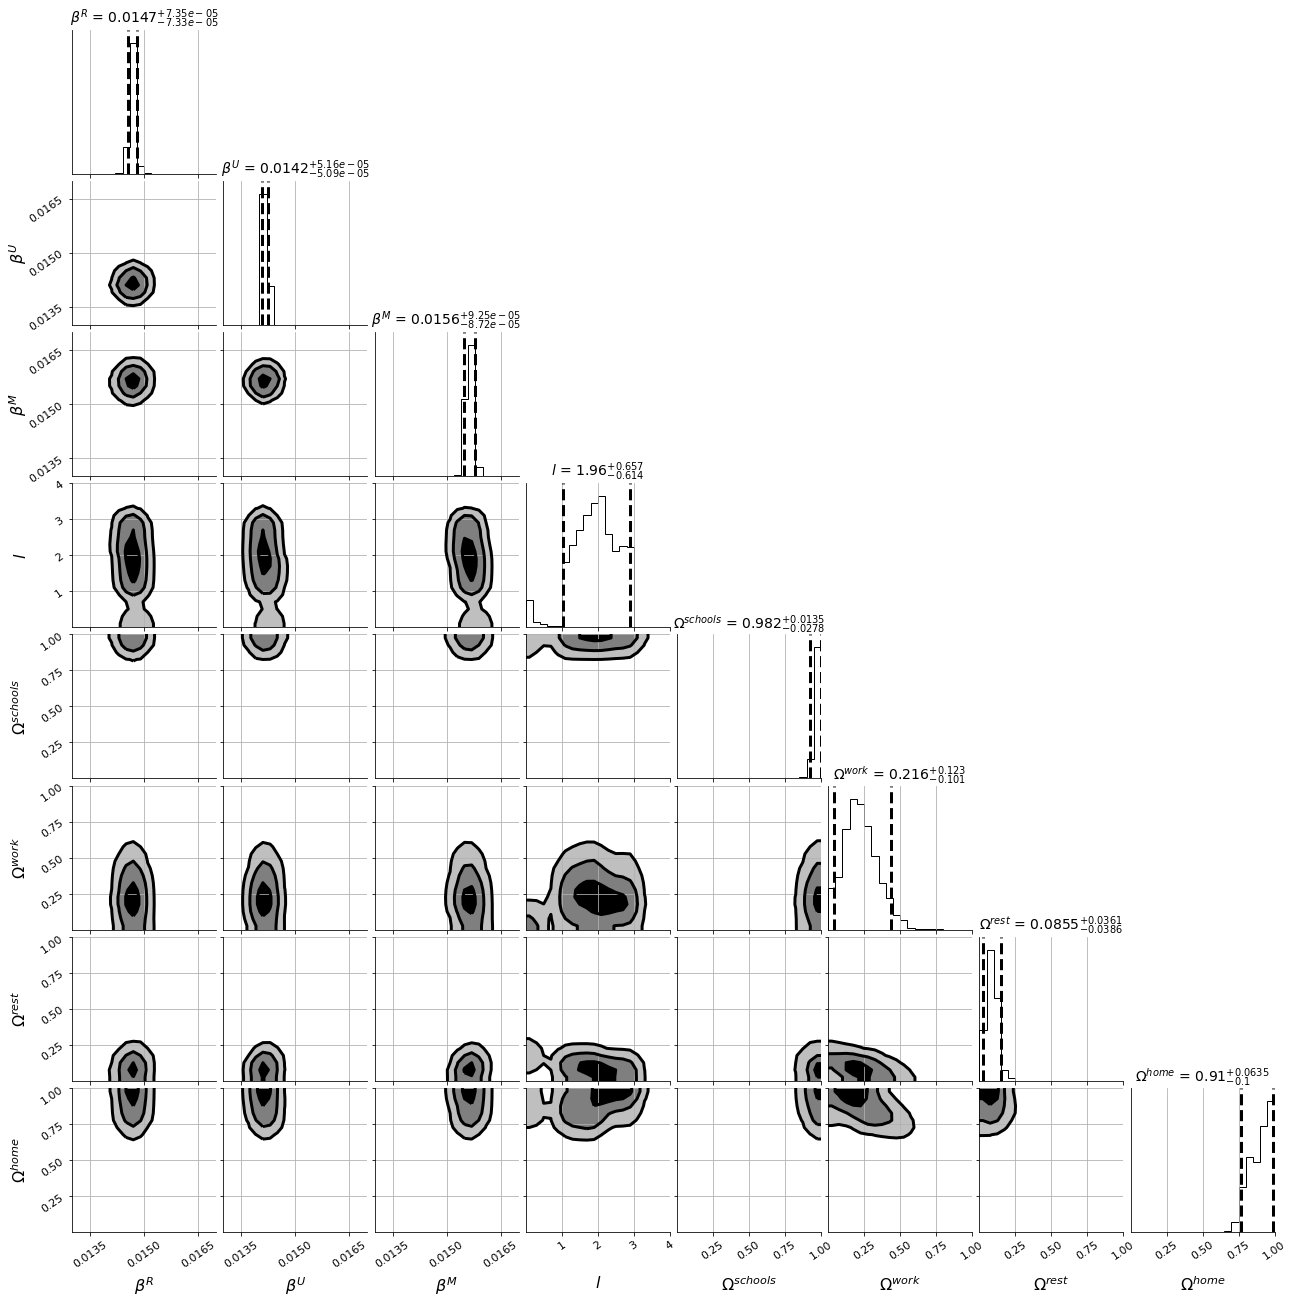

In [6]:
CORNER_KWARGS_WAVE2 = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.0455, 0.9545],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=4,
    title_fmt=".3",
    range=[(0.013, 0.017), (0.013, 0.017), (0.013, 0.017), (0.0, 4.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0),(0.0,1.0)]
)
    # range=[(0.01425, 0.01500), (0.01395, 0.0144), (0.01525, 0.01600), (0.0, 4.0), (0.85, 1.0), (0.0, 0.75), (0.0, 0.2),(0.6,1.0)]
    # range=[(0.02075, 0.02150), (0.02080, 0.02120), (0.02200, 0.02275), (7.2, 9.1), (0.3, 0.9), (0.0, 0.06), (0.25, 0.75)]

# Cornerplots of samples
fig = corner.corner(flat_samples_WAVE2, labels=labels_WAVE2, **CORNER_KWARGS_WAVE2)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=11, rotation=35)

# Save figure
fig.show()
savename_WAVE2 = f'../../results/calibrations/COVID19_SEIRD/arr/cornerplots/{json_name_WAVE2[:-5]}_CORNER.png'
# fig.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [7]:
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=moving_avg, values='hospitalised_IN')

### Time dependant data

In [8]:
# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Social behaviour update function from class __call__ (contact_matrix_4prev) and function wrapper to get the right signature
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation

### Load model

In [10]:
# Load the model parameters dictionary
params_WAVE2 = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params_WAVE2.update({'l' : 5, # formality
               'prev_home' : 0.5, # formality
               'prev_schools': 0.0, # formality
               'prev_work': 0.5, # formality
               'prev_rest': 0.5, # formality
               'relaxdate' : '2021-07-01', # new parameter, only relevant for 2021
               'l_relax' : 31 # new parameter, only relevant for 2021
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params_WAVE2.update({'default_mobility' : None})

# --------------------
# Model initialisation *** this is important, use user-defined fits ***
# --------------------

# User-defined initial states json file
initial_states_WAVE2_date = '2020-08-27'
initial_states_WAVE2_loc = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr'
initial_states_WAVE2_json = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_full-manual-fix.json'
# Initial states, depending on args parser. Taken from WAVE2
with open(f'{initial_states_WAVE2_loc}/{initial_states_WAVE2_json}', 'r') as fp:
    initial_states_WAVE2 = json.load(fp) 

# Initiate model with initial states, defined parameters, and proper time dependent functions
model_WAVE2 = models.COVID19_SEIRD_spatial(initial_states_WAVE2, params_WAVE2, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE2_full_relaxation, 'place' : mobility_wrapper_function}, spatial=agg)

print(f"New hospitalisations at {initial_states_WAVE2_date}: {round(np.sum(initial_states_WAVE2['H_in']),2)}")
print(f"Warmup: {int(samples_dict_WAVE2['warmup'])} days.")

New hospitalisations at 2020-08-27: 24.8
Warmup: 0 days.


In [11]:
if job_WAVE2 == 'R0':
    def draw_fcn_WAVE2(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job_WAVE2 == 'FULL':
    def draw_fcn_WAVE2(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l'] = samples_dict['l'][idx]
        param_dict['prev_schools'] = samples_dict['prev_schools'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        return param_dict

In [12]:
# Why does this start simulating at a different date as job==R0?
# I think this is wrong because it doesn't match with the warmup time
start_sim_WAVE2 = samples_dict_WAVE2[f'start_date_{job_WAVE2}']
# Note that we can choose to simulate further than the calibration date
end_sim_WAVE2 = samples_dict_WAVE2[f'end_date_{job_WAVE2}']
warmup_WAVE2 = samples_dict_WAVE2['warmup']
n_samples_WAVE2 = 100
out_WAVE2 = model_WAVE2.sim(end_sim_WAVE2,start_date=start_sim_WAVE2,warmup=warmup_WAVE2,N=n_samples_WAVE2, \
                draw_fcn=draw_fcn_WAVE2,samples=samples_dict_WAVE2, verbose=True)

In [240]:
# out_WAVE2['H_in'].sum(dim='Nc').sum(dim='place').sel(draws=0).plot()

### Plot calibration fit
Note how this _does not_ plot the full parameter dictionary, but only a sample of size `n_samples`. Surely there is a more complete way of going about?

Note also that the central 'median' line that is plotted, is the result of a single simulation. By definition, it is only in the middle of the band at the peak. That is an important nuance.

In [13]:
df_sciensano_avg = sciensano.get_sciensano_COVID19_data_spatial(agg='arr', moving_avg=True, values='hospitalised_IN')

Text(0, 0.5, '$H_{in}$ (national)')

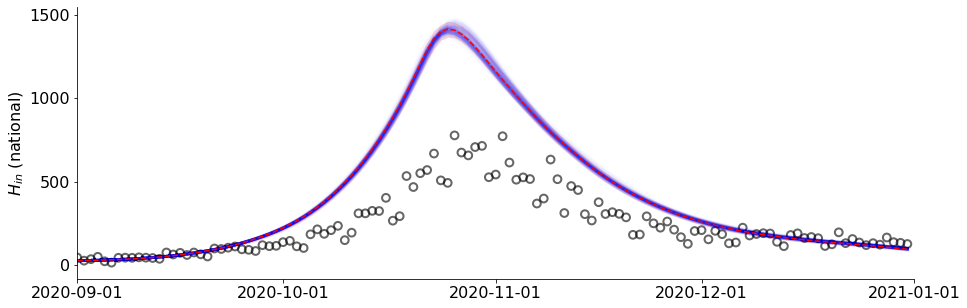

In [19]:
savename_WAVE2 = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE2[:-5]}_FIT.png'
# savename_WAVE2=None
NIS_WAVE2=None

start_calibration_WAVE2 = samples_dict_WAVE2[f'start_date_{job_WAVE2}']
end_calibration_WAVE2 = samples_dict_WAVE2[f'end_date_{job_WAVE2}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw_WAVE2 = plot_calibration_fit(out_WAVE2, df_sciensano, 'H_in', start_sim_WAVE2, end_sim_WAVE2, \
            start_calibration=start_calibration_WAVE2, end_calibration=end_calibration_WAVE2, NIS=NIS_WAVE2, \
            savename=None, conf_int=0.05, show_all=True, ax=ax)

ax.grid(False)
ax.set_xlim(['2020-09-01','2021-01-01'])
ax.set_xticks(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01'])
ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel(r'$H_{in}$ (national)', fontsize=16)
# ax.set_ylim([0, 800])

# plt.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')

(-0.3, 7)

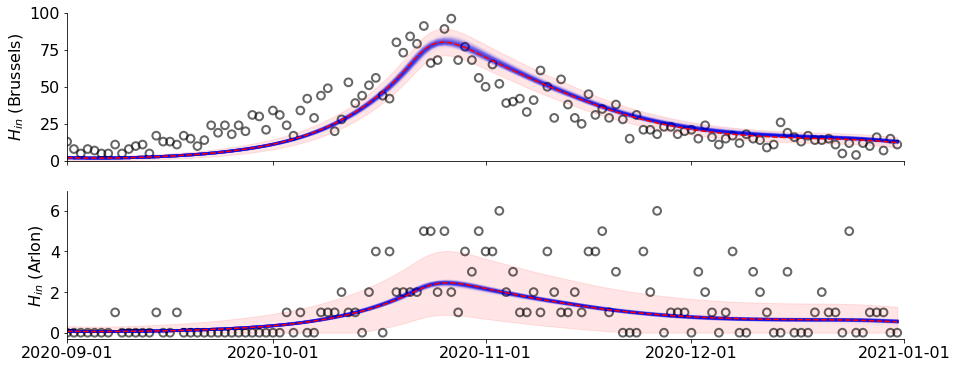

In [66]:
savename_WAVE2 = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE2[:-5]}_FIT.png'
# savename_WAVE2=None
NIS_WAVE2=[21000, 81000]
savename_WAVE2=f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE2[:-5]}_FIT-{NIS_WAVE2[0]}-{NIS_WAVE2[1]}.png'

start_calibration_WAVE2 = samples_dict_WAVE2[f'start_date_{job_WAVE2}']
end_calibration_WAVE2 = samples_dict_WAVE2[f'end_date_{job_WAVE2}']

fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(15,6))

axs[0], median_draw_WAVE2 = plot_calibration_fit(out_WAVE2, df_sciensano, 'H_in', start_sim_WAVE2, end_sim_WAVE2, \
            start_calibration=start_calibration_WAVE2, end_calibration=end_calibration_WAVE2, NIS=NIS_WAVE2[0], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[0])
axs[0].grid(False)

axs[1], median_draw_WAVE2 = plot_calibration_fit(out_WAVE2, df_sciensano, 'H_in', start_sim_WAVE2, end_sim_WAVE2, \
            start_calibration=start_calibration_WAVE2, end_calibration=end_calibration_WAVE2, NIS=NIS_WAVE2[1], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[1])
axs[1].grid(False)
axs[1].set_xlim(['2020-09-01','2021-01-01'])
axs[1].set_xticks(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01'])
axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[0].set_ylabel(r'$H_{in}$ (Brussels)', fontsize=16)
axs[1].set_ylabel(r'$H_{in}$ (Arlon)', fontsize=16)
axs[0].set_ylim([0, 100])
axs[1].set_ylim([-0.3, 7])

# plt.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')

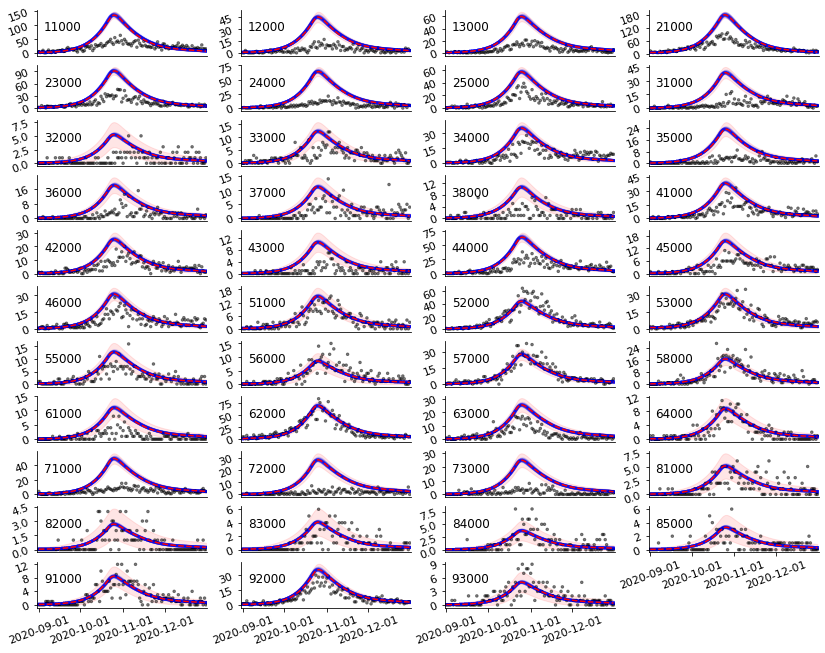

In [20]:
# fig, axs = plt.subplots(ncols=4, nrows=11, sharex=True, figsize=(16,22))

all_NIS = pd.read_csv('../../data/raw/GIS/NIS_arrondissement.csv')['NIS'].values

fig, axs = plt.subplots(nrows=11, ncols=4, sharex=False, figsize=(14, 11))

for row in range(11):
    for col in range(4):
        NIS_index = 4*row+col
        if NIS_index < 43:
            axs[row,col], median_draw_WAVE2 = plot_calibration_fit(out_WAVE2, df_sciensano, 'H_in', start_sim_WAVE2, end_sim_WAVE2, \
            start_calibration=start_calibration_WAVE2, end_calibration=end_calibration_WAVE2, NIS=all_NIS[NIS_index], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[row,col], scatter_size=2)
#             axs[row,col].set_xticks(['2020-03-05', '2020-05-01', '2020-07-01'])
            axs[row,col].set_xticks([])
            axs[row,col].tick_params(axis='both', labelsize=12)
            axs[row,col].set_title(f'{all_NIS[NIS_index]}', y=0.4, x=0.15)
            axs[row,col].set_ylabel(None)
            axs[row,col].grid(False)
            if (row==9 and col==3) or (row==10 and col!=3):
                axs[row,col].set_xticks(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'])
        else:
            axs[row,col].set_visible(False)
            
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=11, rotation=20)
            
savename_WAVE2_all = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE2[:-5]}_FIT-all'
# plt.savefig(savename_WAVE2_all, dpi=400, bbox_inches='tight')

(18494, 18567)

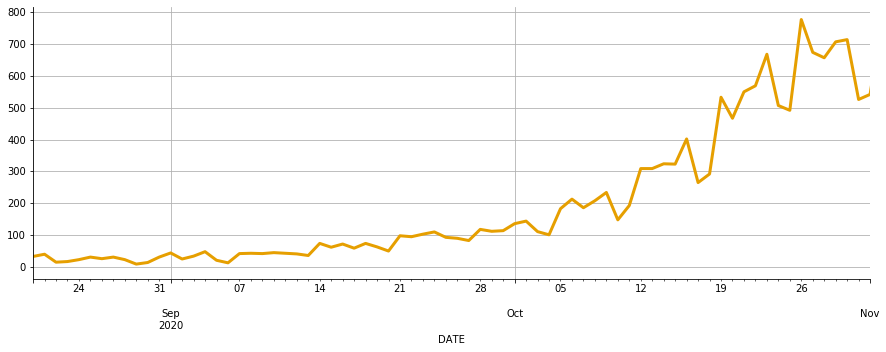

In [247]:
fig, ax = plt.subplots(figsize=(15, 5))
df_sciensano.sum(axis=1).plot(ax=ax)
ax.set_xlim(pd.Timestamp('2020-08-20'), pd.Timestamp('2020-11-01'))

# Postprocessing full pandemic calibration

In [2]:
##################
### USER INPUT ###
##################

# can take a while

# Simulation properties
agg = 'prov'
job = 'FULL'
maxiter = 10
number = 10
date = '2021-10-07' # Date of calibration execution

moving_avg = False

###################

# Automated name
# json_name = f"{agg}_full-pandemic_{job}_test_delete_me_{date}.json"
json_name = 'prov_full-pandemic_FULL_job-FULL_100xPSO_100xMCMC_prov_3-index-in-data_2021-10-08.json'
json_loc = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict = json.load(open(f'{json_loc}/{json_name}'))
parNames_mcmc = ['beta_R', 'beta_U', 'beta_M']
labels = ['$\\beta^R$', '$\\beta^U$', '$\\beta^M$']
if job == 'FULL':
    parNames_mcmc += ['l1', 'l2', \
              'prev_schools', 'prev_work', 'prev_rest_lockdown', 'prev_rest_relaxation', 'prev_home', \
              'K_inf1',  'K_inf2', \
              'amplitude', 'peak_shift']
    labels += ['$l_1$', '$l_2$', \
              '$\\Omega_{schools}$', '$\\Omega_{work}$', '$\\Omega_{rest,lockdown}$', '$\\Omega_{rest,relaxation}$', '$\\Omega_{home}$', \
              '$K_{inf,1}$', '$K_{inf,2}$', \
              '$A$', '$\\phi$']
nwalkers=int(samples_dict[f'n_chains_{job}'])
discard=0 #2000 # see traceplot to distinguish discard and thin values
thin= 1 #50
samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict.keys()

dict_keys(['beta_R', 'beta_U', 'beta_M', 'l1', 'l2', 'prev_schools', 'prev_work', 'prev_rest_lockdown', 'prev_rest_relaxation', 'prev_home', 'K_inf1', 'K_inf2', 'amplitude', 'peak_shift', 'warmup', 'start_date_FULL', 'end_date_FULL', 'n_chains_FULL'])

## Corner Plots

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


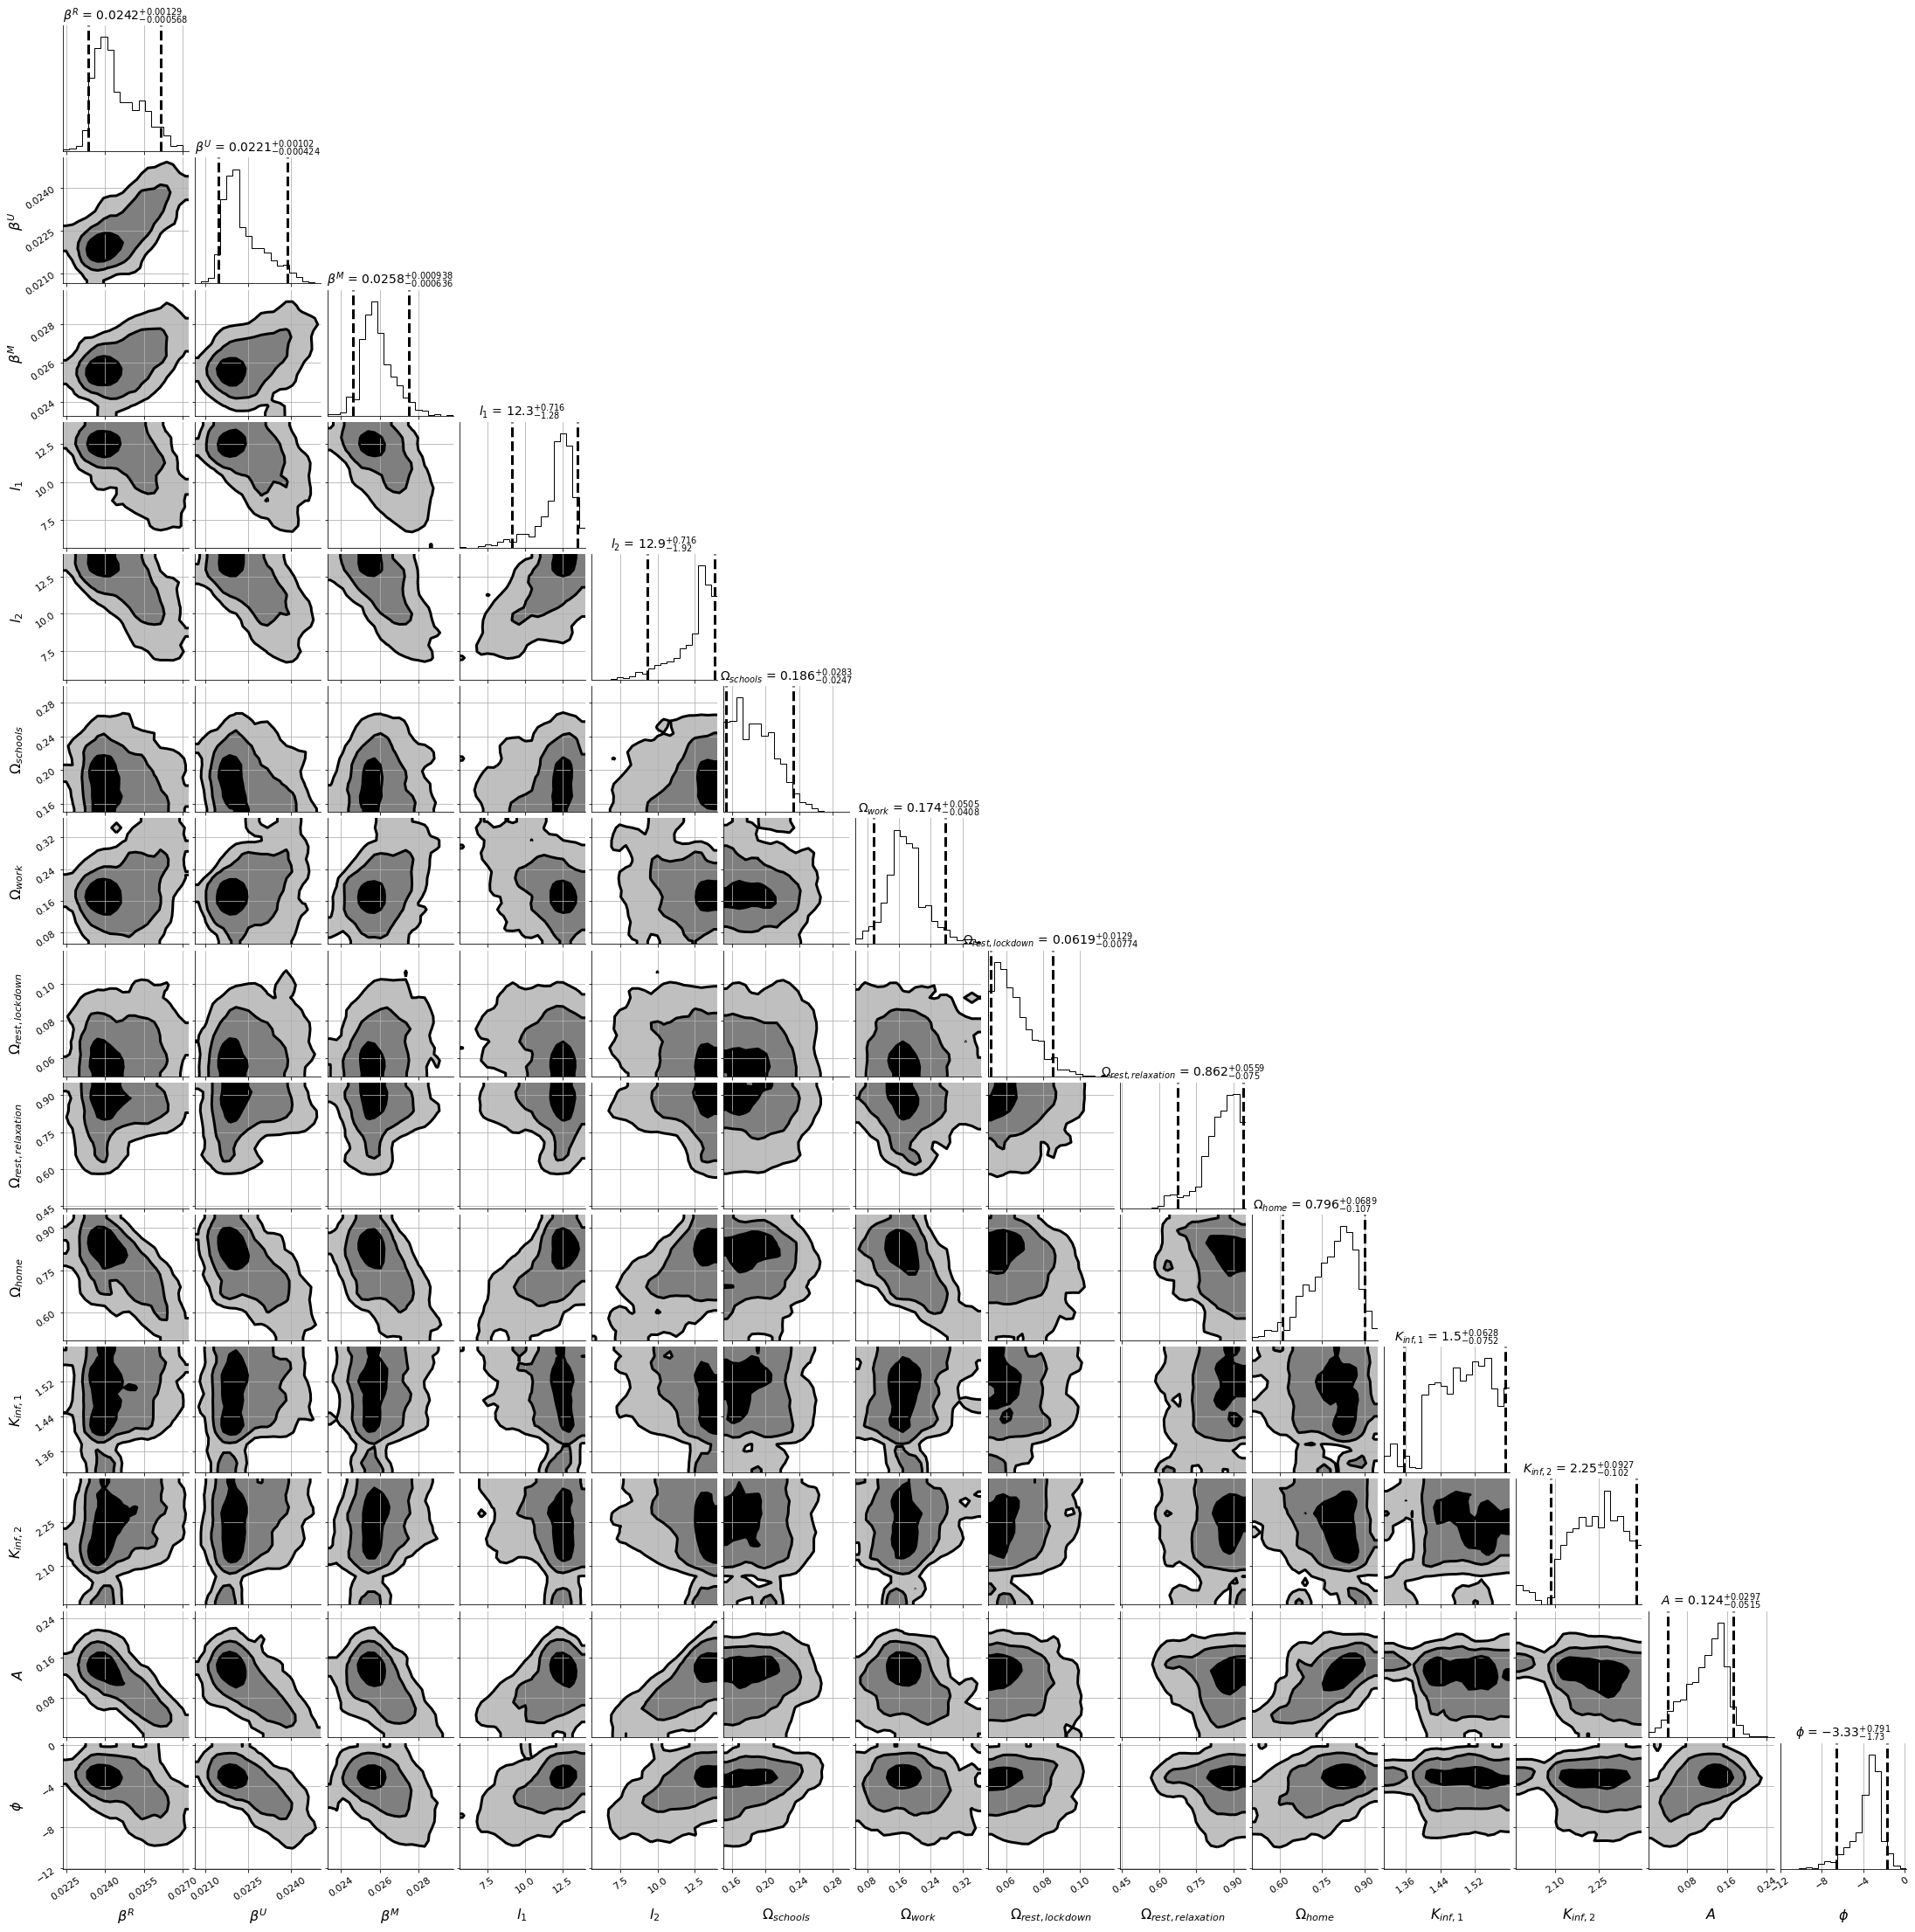

In [3]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.0455, 0.9545],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=4,
    title_fmt=".3"
)
    # range=[(0.01425, 0.01500), (0.01395, 0.0144), (0.01525, 0.01600), (0.0, 4.0), (0.85, 1.0), (0.0, 0.75), (0.0, 0.2),(0.6,1.0)]
    # range=[(0.02075, 0.02150), (0.02080, 0.02120), (0.02200, 0.02275), (7.2, 9.1), (0.3, 0.9), (0.0, 0.06), (0.25, 0.75)]

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=11, rotation=35)

# Save figure
fig.show()
savename = f'../../results/calibrations/COVID19_SEIRD/{agg}/cornerplots/{json_name[:-5]}_CORNER.png'
# fig.savefig(savename, dpi=800, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [4]:
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, \
                                                              make_contact_matrix_function, \
                                                              make_VOC_function, \
                                                              make_vaccination_function, \
                                                              make_seasonality_function

# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters, VOC

# -------------------------------
# Load data: dicts and DataFrames
# -------------------------------

# Total population and contact matrices for the correct aggregation level
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)

# Load and format national VOC data (for time-dependent VOC fraction)
df_VOC_abc = VOC.get_abc_data()

# Load and format local vaccination data, which is also under the sciensano object
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)

# All 36 parameters associated with the full model
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)

# Raw local hospitalisation data used in the calibration. Moving average disabled for calibration
values = 'hospitalised_IN'
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values=values, moving_avg=False)

# ---------------------------------------------
# Load data: time-dependent parameter functions
# ---------------------------------------------

# Time-dependent social contact matrix over all policies, updating Nc
policy_function = make_contact_matrix_function(df_google, Nc_all).policies_all

# Time-dependent mobility function, updating P (place)
mobility_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Time-dependent VOC function, updating alpha
VOC_function = make_VOC_function(df_VOC_abc)

# Time-dependent (first) vaccination function, updating N_vacc
vaccination_function = make_vaccination_function(public_spatial_vaccination_data, spatial=True)

# Time-dependent seasonality function, updating season_factor
seasonality_function = make_seasonality_function()

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:264: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_start = pd.Timestamp(df['INCIDENCE'].ne(0).idxmax()[0], freq='D')
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:265: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_end = pd.Timestamp(df.index[-1][0], freq='D')


In [5]:
# ---------------------
# Load model parameters
# ---------------------

# Reload params first (not necessary but often useful)
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)

# time-dependent social contact parameters in policies_function
params.update({'l1' : 5,
               'l2' : 5,
               'prev_schools' : 0,
               'prev_work' : .5,
               'prev_rest_lockdown' : .5,
               'prev_rest_relaxation' : .5,
               'prev_home' : .5})

# time-dependent mobility parameters in mobility_function
params.update({'default_mobility' : None})

# time-dependent vaccination parameters in vaccination_function
params.update({'initN' : initN,
               'daily_first_dose' : 60000, # copy default values from vaccination_function, which are curently not used I think
               'delay_immunity' : 14,
               'vacc_order' : [8, 7, 6, 5, 4, 3, 2, 1, 0],
               'stop_idx' : 9,
               'refusal' : [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]})

# time-dependent seasonality parameters in seasonality_function
params.update({'season_factor' : 1,
               'amplitude' : 0.1,
               'peak_shift' : 0})

In [6]:
# --------------------
# Model initialisation
# --------------------

# Define the matrix of exposed subjects that will be identified with compartment E
age = -1 # hard-coded as following the demographic distribution
init_number = 3
initE = initial_state(dist='frac', agg=agg, age=age, number=init_number)

# Add the susceptible and exposed population to the initial_states dict
initial_states = {'S': initN-initE, 'E': initE}

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = models.COVID19_SEIRD_spatial_vacc(initial_states, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policy_function,
                                                   'place' : mobility_function,
                                                   'N_vacc' : vaccination_function, 
                                                   'alpha' : VOC_function,
                                                   'season_factor' : seasonality_function})

### Define draw function

In [7]:
if job == 'R0':
    def draw_fcn(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job == 'FULL':
    def draw_fcn(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l1'] = samples_dict['l1'][idx]
        param_dict['l2'] = samples_dict['l2'][idx]
        param_dict['prev_schools'] = samples_dict['prev_schools'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest_lockdown'] = samples_dict['prev_rest_lockdown'][idx]
        param_dict['prev_rest_relaxation'] = samples_dict['prev_rest_relaxation'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['K_inf1'] = samples_dict['K_inf1'][idx]
        param_dict['K_inf2'] = samples_dict['K_inf2'][idx]
        param_dict['amplitude'] = samples_dict['amplitude'][idx]
        param_dict['peak_shift'] = samples_dict['peak_shift'][idx]
        return param_dict

### Simulate

In [8]:
start_sim = samples_dict[f'start_date_{job}']
# Note that we can choose to simulate further than the calibration date
end_sim = samples_dict[f'end_date_{job}']
warmup = samples_dict['warmup']
n_samples = 100
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples, \
                draw_fcn=draw_fcn,samples=samples_dict, verbose=True)

### Plot calibration fit

In [9]:
df_sciensano_avg = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')

Text(0, 0.5, '$H_{in}$ (national)')

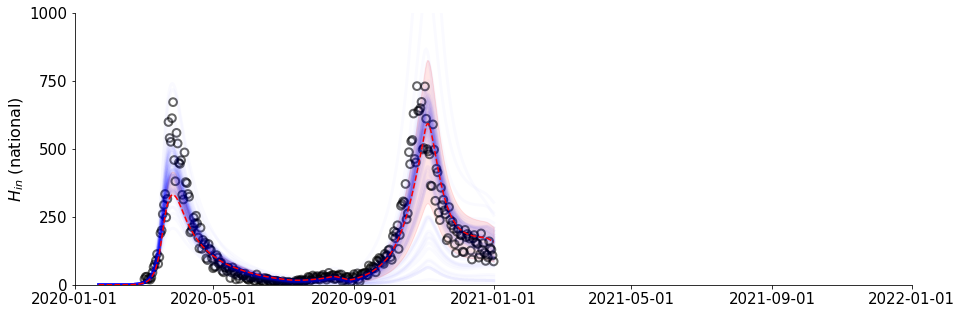

In [10]:
#---------
# NATIONAL
#---------

savename = f'../../results/calibrations/COVID19_SEIRD/{agg}/others/{json_name[:-5]}_FIT.png'
# savename_WAVE2=None
NIS=None

start_calibration = samples_dict[f'start_date_{job}']
end_calibration = samples_dict[f'end_date_{job}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, \
            start_calibration=start_calibration, end_calibration=end_calibration, NIS=NIS, \
            savename=None, conf_int=0.05, show_all=True, ax=ax)

ax.grid(False)
ax.set_xlim(['2020-01-01','2022-01-01'])
ax.set_ylim([0, 1000])
ax.set_xticks(['2020-01-01', '2020-05-01', '2020-09-01', '2021-01-01', '2021-05-01', '2021-09-01', '2022-01-01'])
# ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel(r'$H_{in}$ (national)', fontsize=16)
# ax.set_ylim([0, 800])

# plt.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')

(-0.3, 150.0)

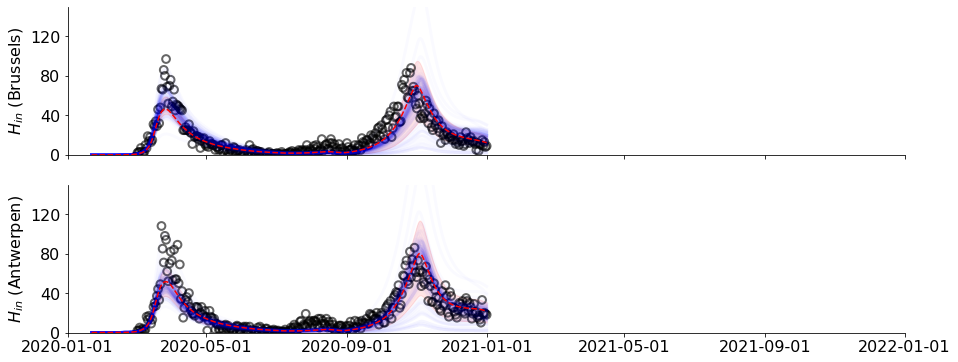

In [14]:
savename = f'../../results/calibrations/COVID19_SEIRD/{agg}/others/{json_name[:-5]}_FIT.png'
# savename_WAVE2=None
NIS=[21000, 10000]
savename=f'../../results/calibrations/COVID19_SEIRD/{agg}/others/{json_name[:-5]}_FIT-{NIS[0]}-{NIS[1]}.png'

start_calibration = samples_dict[f'start_date_{job}']
end_calibration = samples_dict[f'end_date_{job}']

fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(15,6))

axs[0], median_draw = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, \
            start_calibration=start_calibration, end_calibration=end_calibration, NIS=NIS[0], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[0])
axs[0].grid(False)

axs[1], median_draw = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, \
            start_calibration=start_calibration, end_calibration=end_calibration, NIS=NIS[1], \
            savename=None, conf_int=0.05, show_all=True, ax=axs[1])
axs[1].grid(False)
axs[1].set_xlim(['2020-01-01','2022-01-01'])
axs[1].set_xticks(['2020-01-01', '2020-05-01', '2020-09-01', '2021-01-01', '2021-05-01', '2021-09-01', '2022-01-01'])
axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[0].set_ylabel(r'$H_{in}$ (Brussels)', fontsize=16)
axs[1].set_ylabel(r'$H_{in}$ (Antwerpen)', fontsize=16)
axs[0].set_ylim([0, 150])
axs[1].set_ylim([-0.3, 150])

# plt.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')

# Experiment with initial condition

The idea is to consider ...
1. The reported 7-day averaged number of hospitalisations at September 1st
2. The median predicted state contents at September 1st with initial condition `frac` and 3 index patients
3. The median predicted state contents at September 1st with intiial condition `frac` and 9 index patients
4. The ratio $R$ between 1 and the predicted hospitalisations of 2
5. The ratios between all state contents

Extra things to consider:
1. If the ratio is zero, keep the original simulation number
2. Otherwise, change the content of the following categories: E, I, A, M, C

In [11]:
# User-defined initial states json file
initial_states_loc = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr'
initial_states_json = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-02_states_2020-09-01.json'
# Initial states, depending on args parser. Taken from WAVE1
with open(f'{initial_states_loc}/{initial_states_json}', 'r') as fp:
    initial_states = json.load(fp) 

initial_states.keys()

dict_keys(['S', 'E', 'I', 'A', 'M', 'C', 'C_icurec', 'ICU', 'R', 'D', 'H_in', 'H_out', 'H_tot'])

In [12]:
# Sciensano data 7-day average per NIS
# Note that some of these values are zero (no hospitalisations all week)
hosp_sciensano = np.array(sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN').loc['2020-09-01'].values)

# Simulation predictions
hosp_simulation = np.array(initial_states['H_in']).sum(axis=1)

# hosp_sciensano / hosp_simulation

hosp_simulation

array([0.59979978, 0.20547673, 0.27590156, 0.66271511, 0.37662731,
       0.29507318, 0.23141363, 0.18908426, 0.02534094, 0.05834289,
       0.17336864, 0.10933252, 0.09005387, 0.05431518, 0.04818738,
       0.17720063, 0.12098774, 0.05149478, 0.31897146, 0.0730178 ,
       0.14789889, 0.06495674, 0.20363606, 0.13042605, 0.05466197,
       0.03838434, 0.12371492, 0.07495771, 0.05069923, 0.32062569,
       0.11935047, 0.03970895, 0.24123686, 0.14142633, 0.11892774,
       0.02337202, 0.01384573, 0.02023193, 0.01855783, 0.01580759,
       0.0402178 , 0.15677879, 0.02291438])